# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:09<00:00, 6.04KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

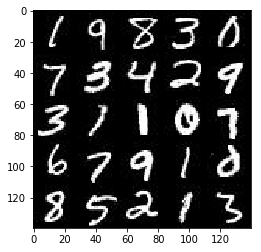

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

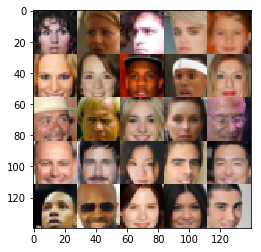

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    r_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='r_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    lr = tf.placeholder(dtype=tf.float32, name='learning_rate')

    return r_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        h1 = tf.layers.batch_normalization(h1, training=True)
        h1 = tf.maximum(0.2 * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(0.2 * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(0.2 * h3, h3)
        
        flat = tf.contrib.layers.flatten(h3)
        
        drop = tf.nn.dropout(x=flat, keep_prob=0.8)
        logits = tf.layers.dense(drop, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [48]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        h1 = tf.layers.dense(z, 5*5*512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        h1 = tf.reshape(h1, (-1, 5, 5, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(0.2 * h1, h1)
        
        h2 = tf.layers.conv2d_transpose(h1, 256, kernel_size=5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(0.2 * h2, h2)
        
        h3 = tf.layers.conv2d_transpose(h2, 256, kernel_size=5, strides=1, padding='valid',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(0.2 * h3, h3)
        
        
        h4 = tf.layers.conv2d_transpose(h3, 128, kernel_size=5, strides=1, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        h4 = tf.layers.batch_normalization(h4, training=is_train)
        h4 = tf.maximum(0.2 * h4, h4)
        
        drop = tf.nn.dropout(x=h4, keep_prob=0.5)
        logits = tf.layers.conv2d_transpose(drop, out_channel_dim, kernel_size=5,strides=2, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [49]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*0.9))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [50]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [51]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [54]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_step = 20
    show_step = 100
    images_to_show = 9
    losses =[]
    step = 0

    _, width, height, channels = data_shape
    
    r_input, z_input, lr = model_inputs(width, height, channels, z_dim)
    
    d_loss, g_loss = model_loss(r_input, z_input, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images = 2*batch_images
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={r_input: batch_images, z_input: z_batch, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: z_batch, r_input: batch_images, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: z_batch, r_input: batch_images, lr: learning_rate})
                
                if step % print_step == 0:
                    train_loss_d = d_loss.eval({z_input: z_batch, r_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_batch})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Step: {}:".format(step),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if step % show_step == 0:
                    show_generator_output(sess, images_to_show, z_input, channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step: 20: Discriminator Loss: 2.2693... Generator Loss: 0.4814
Epoch 1/2... Step: 40: Discriminator Loss: 2.8278... Generator Loss: 0.3534
Epoch 1/2... Step: 60: Discriminator Loss: 1.6552... Generator Loss: 0.5750
Epoch 1/2... Step: 80: Discriminator Loss: 2.1786... Generator Loss: 0.4821
Epoch 1/2... Step: 100: Discriminator Loss: 1.9763... Generator Loss: 0.5600


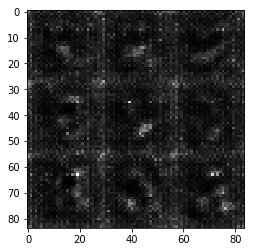

Epoch 1/2... Step: 120: Discriminator Loss: 1.5759... Generator Loss: 0.7120
Epoch 1/2... Step: 140: Discriminator Loss: 1.6783... Generator Loss: 0.5677
Epoch 1/2... Step: 160: Discriminator Loss: 1.7240... Generator Loss: 0.5128
Epoch 1/2... Step: 180: Discriminator Loss: 1.5765... Generator Loss: 0.5946
Epoch 1/2... Step: 200: Discriminator Loss: 1.4688... Generator Loss: 0.6062


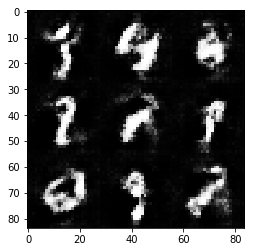

Epoch 1/2... Step: 220: Discriminator Loss: 1.5443... Generator Loss: 0.5865
Epoch 1/2... Step: 240: Discriminator Loss: 1.7126... Generator Loss: 0.4623
Epoch 1/2... Step: 260: Discriminator Loss: 1.5265... Generator Loss: 0.5687
Epoch 1/2... Step: 280: Discriminator Loss: 1.4561... Generator Loss: 0.5519
Epoch 1/2... Step: 300: Discriminator Loss: 1.5929... Generator Loss: 0.5527


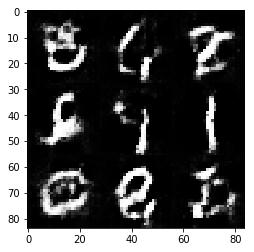

Epoch 1/2... Step: 320: Discriminator Loss: 1.6667... Generator Loss: 0.4594
Epoch 1/2... Step: 340: Discriminator Loss: 1.7578... Generator Loss: 0.7213
Epoch 1/2... Step: 360: Discriminator Loss: 1.5550... Generator Loss: 0.6491
Epoch 1/2... Step: 380: Discriminator Loss: 1.4254... Generator Loss: 0.7458
Epoch 1/2... Step: 400: Discriminator Loss: 1.6823... Generator Loss: 0.6255


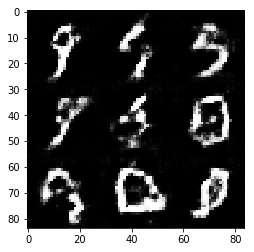

Epoch 1/2... Step: 420: Discriminator Loss: 1.7217... Generator Loss: 0.7139
Epoch 1/2... Step: 440: Discriminator Loss: 1.4502... Generator Loss: 0.8159
Epoch 1/2... Step: 460: Discriminator Loss: 1.4970... Generator Loss: 0.5897
Epoch 1/2... Step: 480: Discriminator Loss: 1.3629... Generator Loss: 0.7937
Epoch 1/2... Step: 500: Discriminator Loss: 1.4804... Generator Loss: 0.7764


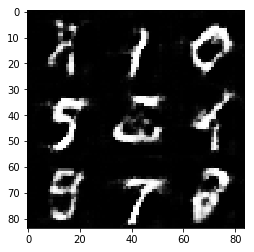

Epoch 1/2... Step: 520: Discriminator Loss: 1.6964... Generator Loss: 0.6330
Epoch 1/2... Step: 540: Discriminator Loss: 1.5200... Generator Loss: 0.5512
Epoch 1/2... Step: 560: Discriminator Loss: 1.3172... Generator Loss: 0.7581
Epoch 1/2... Step: 580: Discriminator Loss: 1.4510... Generator Loss: 0.6645
Epoch 1/2... Step: 600: Discriminator Loss: 1.3525... Generator Loss: 0.6737


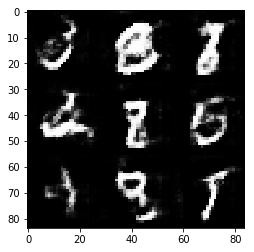

Epoch 1/2... Step: 620: Discriminator Loss: 1.6315... Generator Loss: 0.5969
Epoch 1/2... Step: 640: Discriminator Loss: 1.5465... Generator Loss: 0.6354
Epoch 1/2... Step: 660: Discriminator Loss: 1.5835... Generator Loss: 0.6325
Epoch 1/2... Step: 680: Discriminator Loss: 1.5366... Generator Loss: 0.5206
Epoch 1/2... Step: 700: Discriminator Loss: 1.3854... Generator Loss: 0.6821


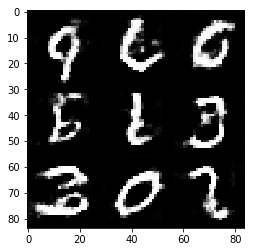

Epoch 1/2... Step: 720: Discriminator Loss: 1.4001... Generator Loss: 0.5372
Epoch 1/2... Step: 740: Discriminator Loss: 1.4248... Generator Loss: 0.6286
Epoch 1/2... Step: 760: Discriminator Loss: 1.5439... Generator Loss: 0.6389
Epoch 1/2... Step: 780: Discriminator Loss: 1.4859... Generator Loss: 0.5495
Epoch 1/2... Step: 800: Discriminator Loss: 1.5532... Generator Loss: 0.5432


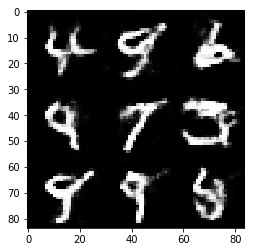

Epoch 1/2... Step: 820: Discriminator Loss: 1.4099... Generator Loss: 0.5409
Epoch 1/2... Step: 840: Discriminator Loss: 1.6167... Generator Loss: 0.4976
Epoch 1/2... Step: 860: Discriminator Loss: 1.4471... Generator Loss: 0.6467
Epoch 1/2... Step: 880: Discriminator Loss: 1.5242... Generator Loss: 0.6669
Epoch 1/2... Step: 900: Discriminator Loss: 1.5679... Generator Loss: 0.6456


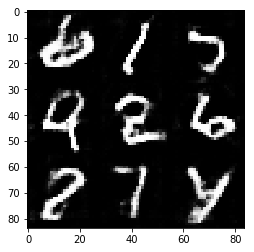

Epoch 1/2... Step: 920: Discriminator Loss: 1.4070... Generator Loss: 0.6185
Epoch 1/2... Step: 940: Discriminator Loss: 1.3954... Generator Loss: 0.7673
Epoch 1/2... Step: 960: Discriminator Loss: 1.5363... Generator Loss: 0.4878
Epoch 1/2... Step: 980: Discriminator Loss: 1.4616... Generator Loss: 0.7106
Epoch 1/2... Step: 1000: Discriminator Loss: 1.4628... Generator Loss: 0.5989


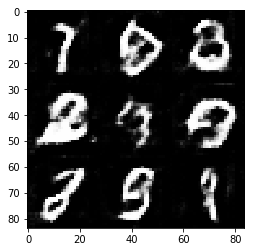

Epoch 1/2... Step: 1020: Discriminator Loss: 1.5218... Generator Loss: 0.5877
Epoch 1/2... Step: 1040: Discriminator Loss: 1.5004... Generator Loss: 0.6315
Epoch 1/2... Step: 1060: Discriminator Loss: 1.4240... Generator Loss: 0.7690
Epoch 1/2... Step: 1080: Discriminator Loss: 1.3787... Generator Loss: 0.6253
Epoch 1/2... Step: 1100: Discriminator Loss: 1.4087... Generator Loss: 0.5673


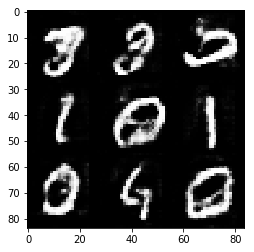

Epoch 1/2... Step: 1120: Discriminator Loss: 1.5181... Generator Loss: 0.6273
Epoch 1/2... Step: 1140: Discriminator Loss: 1.5123... Generator Loss: 0.6154
Epoch 1/2... Step: 1160: Discriminator Loss: 1.5083... Generator Loss: 0.5761
Epoch 1/2... Step: 1180: Discriminator Loss: 1.3161... Generator Loss: 0.7655
Epoch 1/2... Step: 1200: Discriminator Loss: 1.5149... Generator Loss: 0.6377


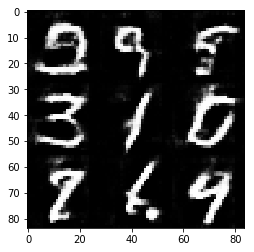

Epoch 1/2... Step: 1220: Discriminator Loss: 1.2700... Generator Loss: 0.6526
Epoch 1/2... Step: 1240: Discriminator Loss: 1.5489... Generator Loss: 0.5597
Epoch 1/2... Step: 1260: Discriminator Loss: 1.4408... Generator Loss: 0.5618
Epoch 1/2... Step: 1280: Discriminator Loss: 1.4141... Generator Loss: 0.6992
Epoch 1/2... Step: 1300: Discriminator Loss: 1.5343... Generator Loss: 0.6324


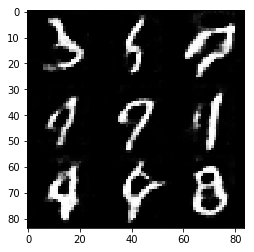

Epoch 1/2... Step: 1320: Discriminator Loss: 1.5491... Generator Loss: 0.7009
Epoch 1/2... Step: 1340: Discriminator Loss: 1.3391... Generator Loss: 0.9692
Epoch 1/2... Step: 1360: Discriminator Loss: 1.4454... Generator Loss: 0.6691
Epoch 1/2... Step: 1380: Discriminator Loss: 1.4731... Generator Loss: 0.8023
Epoch 1/2... Step: 1400: Discriminator Loss: 1.4203... Generator Loss: 0.7009


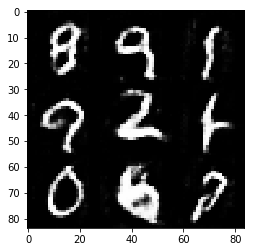

Epoch 1/2... Step: 1420: Discriminator Loss: 1.3879... Generator Loss: 0.6943
Epoch 1/2... Step: 1440: Discriminator Loss: 1.4171... Generator Loss: 0.6543
Epoch 1/2... Step: 1460: Discriminator Loss: 1.4368... Generator Loss: 0.5926
Epoch 1/2... Step: 1480: Discriminator Loss: 1.4431... Generator Loss: 0.6507
Epoch 1/2... Step: 1500: Discriminator Loss: 1.6454... Generator Loss: 0.4670


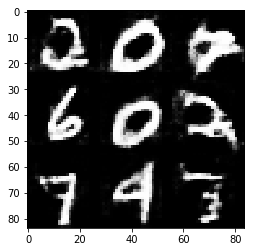

Epoch 1/2... Step: 1520: Discriminator Loss: 1.5003... Generator Loss: 0.6974
Epoch 1/2... Step: 1540: Discriminator Loss: 1.5602... Generator Loss: 0.6020
Epoch 1/2... Step: 1560: Discriminator Loss: 1.4582... Generator Loss: 0.7545
Epoch 1/2... Step: 1580: Discriminator Loss: 1.4098... Generator Loss: 0.6874
Epoch 1/2... Step: 1600: Discriminator Loss: 1.4750... Generator Loss: 0.6235


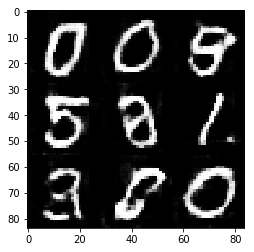

Epoch 1/2... Step: 1620: Discriminator Loss: 1.4637... Generator Loss: 0.5649
Epoch 1/2... Step: 1640: Discriminator Loss: 1.4499... Generator Loss: 0.5776
Epoch 1/2... Step: 1660: Discriminator Loss: 1.4445... Generator Loss: 0.7154
Epoch 1/2... Step: 1680: Discriminator Loss: 1.5190... Generator Loss: 0.5779
Epoch 1/2... Step: 1700: Discriminator Loss: 1.5294... Generator Loss: 0.5163


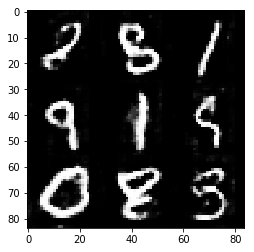

Epoch 1/2... Step: 1720: Discriminator Loss: 1.5164... Generator Loss: 0.6029
Epoch 1/2... Step: 1740: Discriminator Loss: 1.4383... Generator Loss: 0.6145
Epoch 1/2... Step: 1760: Discriminator Loss: 1.4633... Generator Loss: 0.5787
Epoch 1/2... Step: 1780: Discriminator Loss: 1.4965... Generator Loss: 0.5621
Epoch 1/2... Step: 1800: Discriminator Loss: 1.4497... Generator Loss: 0.6287


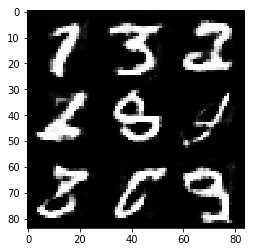

Epoch 1/2... Step: 1820: Discriminator Loss: 1.3534... Generator Loss: 0.6263
Epoch 1/2... Step: 1840: Discriminator Loss: 1.4285... Generator Loss: 0.6286
Epoch 1/2... Step: 1860: Discriminator Loss: 1.4705... Generator Loss: 0.5592
Epoch 2/2... Step: 1880: Discriminator Loss: 1.4090... Generator Loss: 0.7385
Epoch 2/2... Step: 1900: Discriminator Loss: 1.6461... Generator Loss: 0.4660


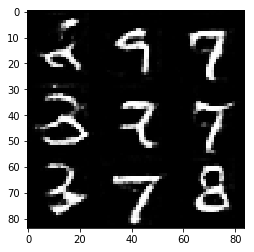

Epoch 2/2... Step: 1920: Discriminator Loss: 1.5237... Generator Loss: 0.7606
Epoch 2/2... Step: 1940: Discriminator Loss: 1.3828... Generator Loss: 0.6364
Epoch 2/2... Step: 1960: Discriminator Loss: 1.5199... Generator Loss: 0.9681
Epoch 2/2... Step: 1980: Discriminator Loss: 1.6576... Generator Loss: 0.6628
Epoch 2/2... Step: 2000: Discriminator Loss: 1.3536... Generator Loss: 0.5688


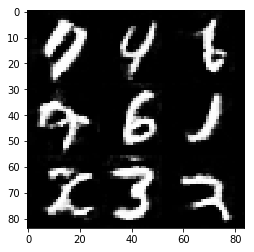

Epoch 2/2... Step: 2020: Discriminator Loss: 1.3421... Generator Loss: 0.6523
Epoch 2/2... Step: 2040: Discriminator Loss: 1.2917... Generator Loss: 0.7197
Epoch 2/2... Step: 2060: Discriminator Loss: 1.4123... Generator Loss: 0.5758
Epoch 2/2... Step: 2080: Discriminator Loss: 1.2613... Generator Loss: 0.7380
Epoch 2/2... Step: 2100: Discriminator Loss: 1.4657... Generator Loss: 0.6596


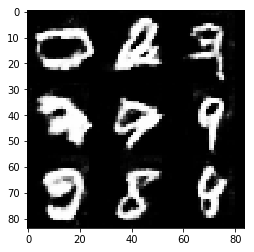

Epoch 2/2... Step: 2120: Discriminator Loss: 1.2348... Generator Loss: 0.6152
Epoch 2/2... Step: 2140: Discriminator Loss: 1.2440... Generator Loss: 0.6959
Epoch 2/2... Step: 2160: Discriminator Loss: 1.2705... Generator Loss: 0.5355
Epoch 2/2... Step: 2180: Discriminator Loss: 1.3147... Generator Loss: 0.7214
Epoch 2/2... Step: 2200: Discriminator Loss: 1.2842... Generator Loss: 0.7724


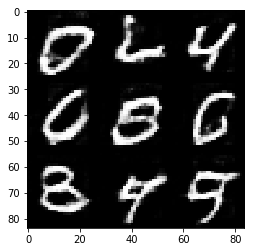

Epoch 2/2... Step: 2220: Discriminator Loss: 1.5313... Generator Loss: 0.4861
Epoch 2/2... Step: 2240: Discriminator Loss: 1.2978... Generator Loss: 0.7818
Epoch 2/2... Step: 2260: Discriminator Loss: 1.4249... Generator Loss: 0.9081
Epoch 2/2... Step: 2280: Discriminator Loss: 1.4477... Generator Loss: 0.4677
Epoch 2/2... Step: 2300: Discriminator Loss: 1.2663... Generator Loss: 0.8820


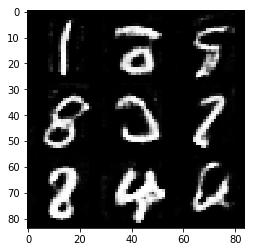

Epoch 2/2... Step: 2320: Discriminator Loss: 1.3954... Generator Loss: 0.7806
Epoch 2/2... Step: 2340: Discriminator Loss: 1.3594... Generator Loss: 0.5364
Epoch 2/2... Step: 2360: Discriminator Loss: 1.1670... Generator Loss: 0.7609
Epoch 2/2... Step: 2380: Discriminator Loss: 1.3893... Generator Loss: 0.5590
Epoch 2/2... Step: 2400: Discriminator Loss: 1.2252... Generator Loss: 0.6474


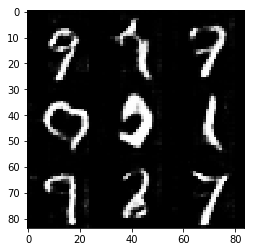

Epoch 2/2... Step: 2420: Discriminator Loss: 1.2184... Generator Loss: 0.6314
Epoch 2/2... Step: 2440: Discriminator Loss: 1.1904... Generator Loss: 0.8748
Epoch 2/2... Step: 2460: Discriminator Loss: 1.2549... Generator Loss: 0.8532
Epoch 2/2... Step: 2480: Discriminator Loss: 1.3673... Generator Loss: 0.5871
Epoch 2/2... Step: 2500: Discriminator Loss: 1.2772... Generator Loss: 0.5915


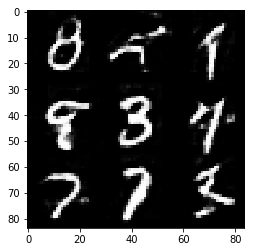

Epoch 2/2... Step: 2520: Discriminator Loss: 1.2646... Generator Loss: 0.7352
Epoch 2/2... Step: 2540: Discriminator Loss: 1.2019... Generator Loss: 0.7671
Epoch 2/2... Step: 2560: Discriminator Loss: 1.2990... Generator Loss: 0.8662
Epoch 2/2... Step: 2580: Discriminator Loss: 1.1856... Generator Loss: 1.0002
Epoch 2/2... Step: 2600: Discriminator Loss: 1.1106... Generator Loss: 0.9038


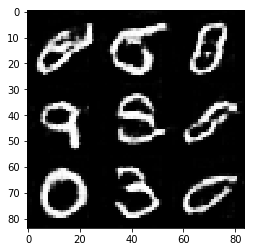

Epoch 2/2... Step: 2620: Discriminator Loss: 1.0006... Generator Loss: 0.6603
Epoch 2/2... Step: 2640: Discriminator Loss: 1.4859... Generator Loss: 0.5626
Epoch 2/2... Step: 2660: Discriminator Loss: 1.0210... Generator Loss: 0.8878
Epoch 2/2... Step: 2680: Discriminator Loss: 1.2182... Generator Loss: 0.7387
Epoch 2/2... Step: 2700: Discriminator Loss: 1.3586... Generator Loss: 0.5383


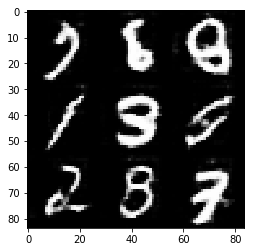

Epoch 2/2... Step: 2720: Discriminator Loss: 1.0729... Generator Loss: 0.8474
Epoch 2/2... Step: 2740: Discriminator Loss: 1.0012... Generator Loss: 0.8482
Epoch 2/2... Step: 2760: Discriminator Loss: 0.9764... Generator Loss: 1.0132
Epoch 2/2... Step: 2780: Discriminator Loss: 1.1227... Generator Loss: 0.8906
Epoch 2/2... Step: 2800: Discriminator Loss: 1.3309... Generator Loss: 0.7015


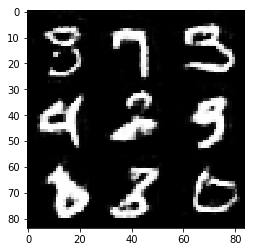

Epoch 2/2... Step: 2820: Discriminator Loss: 1.0660... Generator Loss: 1.3444
Epoch 2/2... Step: 2840: Discriminator Loss: 1.4020... Generator Loss: 0.6845
Epoch 2/2... Step: 2860: Discriminator Loss: 1.2000... Generator Loss: 0.5658
Epoch 2/2... Step: 2880: Discriminator Loss: 1.6120... Generator Loss: 0.5070
Epoch 2/2... Step: 2900: Discriminator Loss: 1.1055... Generator Loss: 0.7321


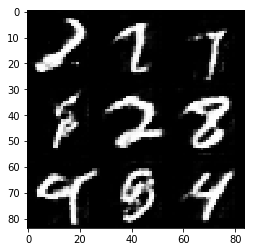

Epoch 2/2... Step: 2920: Discriminator Loss: 1.2598... Generator Loss: 0.6115
Epoch 2/2... Step: 2940: Discriminator Loss: 1.1021... Generator Loss: 1.0451
Epoch 2/2... Step: 2960: Discriminator Loss: 1.2849... Generator Loss: 0.4642
Epoch 2/2... Step: 2980: Discriminator Loss: 1.2206... Generator Loss: 0.9421
Epoch 2/2... Step: 3000: Discriminator Loss: 1.0515... Generator Loss: 0.8059


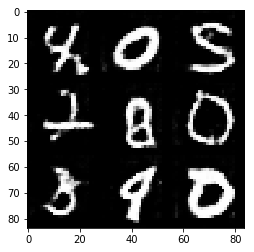

Epoch 2/2... Step: 3020: Discriminator Loss: 1.2968... Generator Loss: 0.5628
Epoch 2/2... Step: 3040: Discriminator Loss: 1.3599... Generator Loss: 0.5433
Epoch 2/2... Step: 3060: Discriminator Loss: 1.3015... Generator Loss: 0.7646
Epoch 2/2... Step: 3080: Discriminator Loss: 1.1641... Generator Loss: 0.8452
Epoch 2/2... Step: 3100: Discriminator Loss: 1.1066... Generator Loss: 0.8419


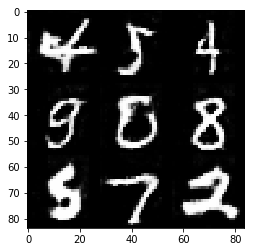

Epoch 2/2... Step: 3120: Discriminator Loss: 0.9872... Generator Loss: 0.9186
Epoch 2/2... Step: 3140: Discriminator Loss: 1.2242... Generator Loss: 0.8630
Epoch 2/2... Step: 3160: Discriminator Loss: 1.1250... Generator Loss: 0.7562
Epoch 2/2... Step: 3180: Discriminator Loss: 1.3423... Generator Loss: 0.5630
Epoch 2/2... Step: 3200: Discriminator Loss: 0.9679... Generator Loss: 1.0214


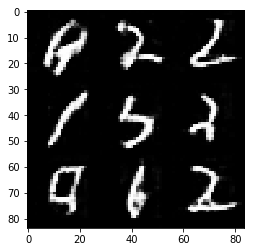

Epoch 2/2... Step: 3220: Discriminator Loss: 1.2092... Generator Loss: 1.0406
Epoch 2/2... Step: 3240: Discriminator Loss: 0.8694... Generator Loss: 1.1064
Epoch 2/2... Step: 3260: Discriminator Loss: 1.1716... Generator Loss: 0.6282
Epoch 2/2... Step: 3280: Discriminator Loss: 1.0899... Generator Loss: 0.7707
Epoch 2/2... Step: 3300: Discriminator Loss: 1.1532... Generator Loss: 0.8494


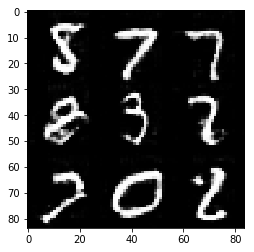

Epoch 2/2... Step: 3320: Discriminator Loss: 1.4974... Generator Loss: 0.6177
Epoch 2/2... Step: 3340: Discriminator Loss: 1.9171... Generator Loss: 1.0169
Epoch 2/2... Step: 3360: Discriminator Loss: 1.1454... Generator Loss: 0.6678
Epoch 2/2... Step: 3380: Discriminator Loss: 1.3971... Generator Loss: 0.5749
Epoch 2/2... Step: 3400: Discriminator Loss: 1.1442... Generator Loss: 0.7073


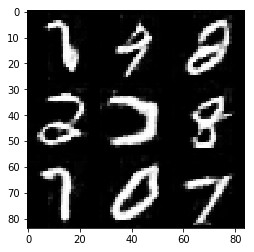

Epoch 2/2... Step: 3420: Discriminator Loss: 1.1384... Generator Loss: 0.7869
Epoch 2/2... Step: 3440: Discriminator Loss: 1.1161... Generator Loss: 0.6709
Epoch 2/2... Step: 3460: Discriminator Loss: 1.0440... Generator Loss: 0.7965
Epoch 2/2... Step: 3480: Discriminator Loss: 1.4057... Generator Loss: 0.6035
Epoch 2/2... Step: 3500: Discriminator Loss: 1.2515... Generator Loss: 0.6611


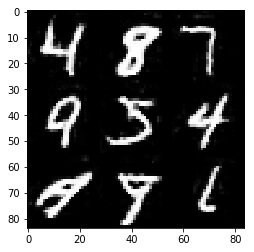

Epoch 2/2... Step: 3520: Discriminator Loss: 1.0488... Generator Loss: 0.7610
Epoch 2/2... Step: 3540: Discriminator Loss: 1.3645... Generator Loss: 0.5506
Epoch 2/2... Step: 3560: Discriminator Loss: 1.0472... Generator Loss: 0.9891
Epoch 2/2... Step: 3580: Discriminator Loss: 0.9043... Generator Loss: 1.0660
Epoch 2/2... Step: 3600: Discriminator Loss: 0.9756... Generator Loss: 0.9922


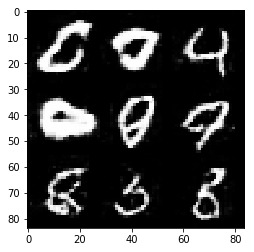

Epoch 2/2... Step: 3620: Discriminator Loss: 1.1967... Generator Loss: 0.8755
Epoch 2/2... Step: 3640: Discriminator Loss: 1.0709... Generator Loss: 0.8395
Epoch 2/2... Step: 3660: Discriminator Loss: 1.2867... Generator Loss: 0.6791
Epoch 2/2... Step: 3680: Discriminator Loss: 1.4252... Generator Loss: 0.7056
Epoch 2/2... Step: 3700: Discriminator Loss: 1.1348... Generator Loss: 0.5328


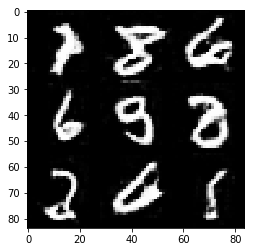

Epoch 2/2... Step: 3720: Discriminator Loss: 1.3864... Generator Loss: 0.8394
Epoch 2/2... Step: 3740: Discriminator Loss: 1.3238... Generator Loss: 0.7759


In [55]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step: 20: Discriminator Loss: 3.7883... Generator Loss: 0.3474
Epoch 1/1... Step: 40: Discriminator Loss: 3.5931... Generator Loss: 0.3648
Epoch 1/1... Step: 60: Discriminator Loss: 1.6229... Generator Loss: 0.8786
Epoch 1/1... Step: 80: Discriminator Loss: 1.0770... Generator Loss: 1.3406
Epoch 1/1... Step: 100: Discriminator Loss: 1.0161... Generator Loss: 1.1640


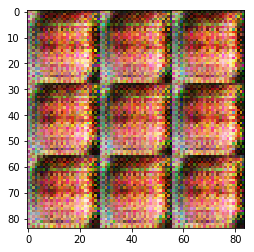

Epoch 1/1... Step: 120: Discriminator Loss: 1.5299... Generator Loss: 0.6701
Epoch 1/1... Step: 140: Discriminator Loss: 1.6941... Generator Loss: 0.7381
Epoch 1/1... Step: 160: Discriminator Loss: 1.6079... Generator Loss: 0.6044
Epoch 1/1... Step: 180: Discriminator Loss: 1.7608... Generator Loss: 0.7651
Epoch 1/1... Step: 200: Discriminator Loss: 1.5783... Generator Loss: 0.6713


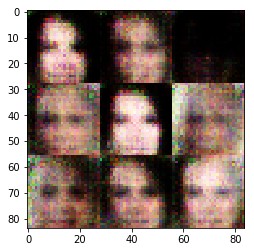

Epoch 1/1... Step: 220: Discriminator Loss: 1.7113... Generator Loss: 0.5664
Epoch 1/1... Step: 240: Discriminator Loss: 1.5699... Generator Loss: 0.6459
Epoch 1/1... Step: 260: Discriminator Loss: 1.4048... Generator Loss: 0.6807
Epoch 1/1... Step: 280: Discriminator Loss: 1.6399... Generator Loss: 0.7365
Epoch 1/1... Step: 300: Discriminator Loss: 1.6406... Generator Loss: 0.5842


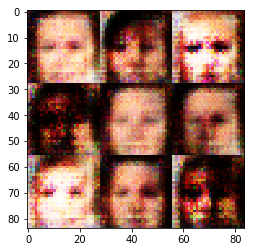

Epoch 1/1... Step: 320: Discriminator Loss: 1.4627... Generator Loss: 0.6124
Epoch 1/1... Step: 340: Discriminator Loss: 1.8116... Generator Loss: 0.8031
Epoch 1/1... Step: 360: Discriminator Loss: 1.8083... Generator Loss: 0.5469
Epoch 1/1... Step: 380: Discriminator Loss: 1.6707... Generator Loss: 0.6251
Epoch 1/1... Step: 400: Discriminator Loss: 1.5383... Generator Loss: 0.6479


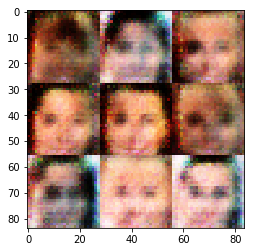

Epoch 1/1... Step: 420: Discriminator Loss: 1.6644... Generator Loss: 0.6018
Epoch 1/1... Step: 440: Discriminator Loss: 1.5374... Generator Loss: 0.6460
Epoch 1/1... Step: 460: Discriminator Loss: 1.4506... Generator Loss: 0.6353
Epoch 1/1... Step: 480: Discriminator Loss: 1.6445... Generator Loss: 0.5675
Epoch 1/1... Step: 500: Discriminator Loss: 1.6684... Generator Loss: 0.6893


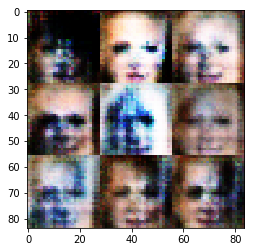

Epoch 1/1... Step: 520: Discriminator Loss: 1.7735... Generator Loss: 0.5655
Epoch 1/1... Step: 540: Discriminator Loss: 1.4843... Generator Loss: 0.7219
Epoch 1/1... Step: 560: Discriminator Loss: 1.4836... Generator Loss: 0.6507
Epoch 1/1... Step: 580: Discriminator Loss: 1.6378... Generator Loss: 0.5184
Epoch 1/1... Step: 600: Discriminator Loss: 1.6344... Generator Loss: 0.5372


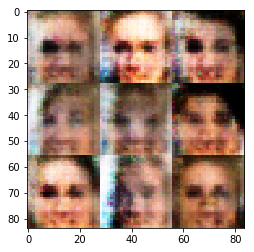

Epoch 1/1... Step: 620: Discriminator Loss: 1.5872... Generator Loss: 0.6639
Epoch 1/1... Step: 640: Discriminator Loss: 1.6196... Generator Loss: 0.7021
Epoch 1/1... Step: 660: Discriminator Loss: 1.4564... Generator Loss: 0.6366
Epoch 1/1... Step: 680: Discriminator Loss: 1.8391... Generator Loss: 0.5544
Epoch 1/1... Step: 700: Discriminator Loss: 1.7068... Generator Loss: 0.6458


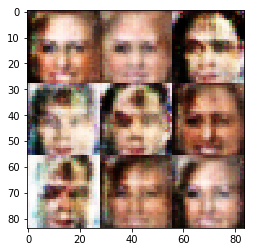

Epoch 1/1... Step: 720: Discriminator Loss: 1.6118... Generator Loss: 0.6652
Epoch 1/1... Step: 740: Discriminator Loss: 1.4738... Generator Loss: 0.7206
Epoch 1/1... Step: 760: Discriminator Loss: 1.5948... Generator Loss: 0.6192
Epoch 1/1... Step: 780: Discriminator Loss: 1.6159... Generator Loss: 0.6386
Epoch 1/1... Step: 800: Discriminator Loss: 1.5222... Generator Loss: 0.6680


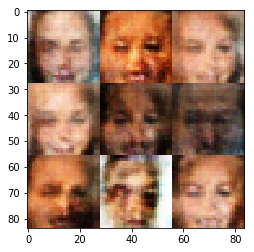

Epoch 1/1... Step: 820: Discriminator Loss: 1.5409... Generator Loss: 0.6337
Epoch 1/1... Step: 840: Discriminator Loss: 1.6164... Generator Loss: 0.6360
Epoch 1/1... Step: 860: Discriminator Loss: 1.5190... Generator Loss: 0.6348
Epoch 1/1... Step: 880: Discriminator Loss: 1.6117... Generator Loss: 0.6363
Epoch 1/1... Step: 900: Discriminator Loss: 1.6535... Generator Loss: 0.6005


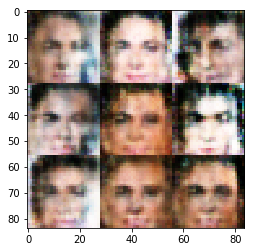

Epoch 1/1... Step: 920: Discriminator Loss: 1.5361... Generator Loss: 0.6769
Epoch 1/1... Step: 940: Discriminator Loss: 1.4892... Generator Loss: 0.6566
Epoch 1/1... Step: 960: Discriminator Loss: 1.6306... Generator Loss: 0.6428
Epoch 1/1... Step: 980: Discriminator Loss: 1.5580... Generator Loss: 0.6210
Epoch 1/1... Step: 1000: Discriminator Loss: 1.5918... Generator Loss: 0.6810


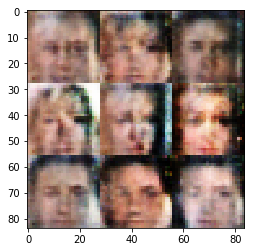

Epoch 1/1... Step: 1020: Discriminator Loss: 1.5503... Generator Loss: 0.6833
Epoch 1/1... Step: 1040: Discriminator Loss: 1.7072... Generator Loss: 0.6113
Epoch 1/1... Step: 1060: Discriminator Loss: 1.4968... Generator Loss: 0.7318
Epoch 1/1... Step: 1080: Discriminator Loss: 1.5940... Generator Loss: 0.5923
Epoch 1/1... Step: 1100: Discriminator Loss: 1.5791... Generator Loss: 0.6785


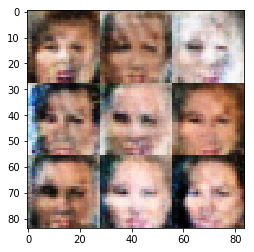

Epoch 1/1... Step: 1120: Discriminator Loss: 1.5965... Generator Loss: 0.6450
Epoch 1/1... Step: 1140: Discriminator Loss: 1.5531... Generator Loss: 0.5706
Epoch 1/1... Step: 1160: Discriminator Loss: 1.4537... Generator Loss: 0.6813
Epoch 1/1... Step: 1180: Discriminator Loss: 1.4357... Generator Loss: 0.6592
Epoch 1/1... Step: 1200: Discriminator Loss: 1.4661... Generator Loss: 0.6809


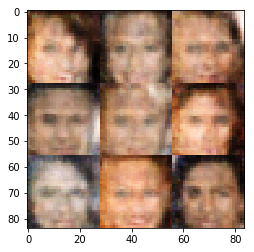

Epoch 1/1... Step: 1220: Discriminator Loss: 1.5341... Generator Loss: 0.6497
Epoch 1/1... Step: 1240: Discriminator Loss: 1.4239... Generator Loss: 0.6323
Epoch 1/1... Step: 1260: Discriminator Loss: 1.4939... Generator Loss: 0.6973
Epoch 1/1... Step: 1280: Discriminator Loss: 1.4804... Generator Loss: 0.6887
Epoch 1/1... Step: 1300: Discriminator Loss: 1.5898... Generator Loss: 0.6732


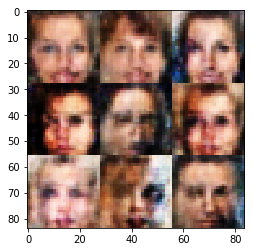

Epoch 1/1... Step: 1320: Discriminator Loss: 1.4919... Generator Loss: 0.7386
Epoch 1/1... Step: 1340: Discriminator Loss: 1.5491... Generator Loss: 0.6847
Epoch 1/1... Step: 1360: Discriminator Loss: 1.5092... Generator Loss: 0.6316
Epoch 1/1... Step: 1380: Discriminator Loss: 1.4613... Generator Loss: 0.6467
Epoch 1/1... Step: 1400: Discriminator Loss: 1.4599... Generator Loss: 0.6556


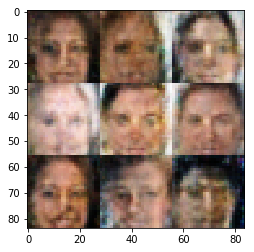

Epoch 1/1... Step: 1420: Discriminator Loss: 1.4182... Generator Loss: 0.6652
Epoch 1/1... Step: 1440: Discriminator Loss: 1.4436... Generator Loss: 0.6304
Epoch 1/1... Step: 1460: Discriminator Loss: 1.4984... Generator Loss: 0.6544
Epoch 1/1... Step: 1480: Discriminator Loss: 1.6534... Generator Loss: 0.7118
Epoch 1/1... Step: 1500: Discriminator Loss: 1.4781... Generator Loss: 0.7005


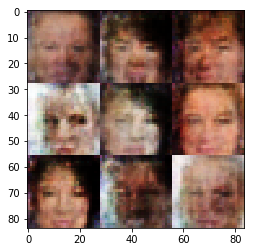

Epoch 1/1... Step: 1520: Discriminator Loss: 1.4693... Generator Loss: 0.6939
Epoch 1/1... Step: 1540: Discriminator Loss: 1.5637... Generator Loss: 0.6552
Epoch 1/1... Step: 1560: Discriminator Loss: 1.5826... Generator Loss: 0.6597
Epoch 1/1... Step: 1580: Discriminator Loss: 1.4362... Generator Loss: 0.6654
Epoch 1/1... Step: 1600: Discriminator Loss: 1.4635... Generator Loss: 0.6349


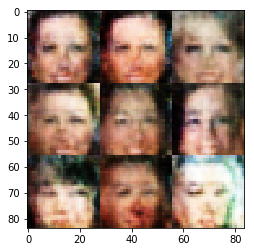

Epoch 1/1... Step: 1620: Discriminator Loss: 1.4735... Generator Loss: 0.6631
Epoch 1/1... Step: 1640: Discriminator Loss: 1.4351... Generator Loss: 0.7058
Epoch 1/1... Step: 1660: Discriminator Loss: 1.5079... Generator Loss: 0.6269
Epoch 1/1... Step: 1680: Discriminator Loss: 1.5816... Generator Loss: 0.5997
Epoch 1/1... Step: 1700: Discriminator Loss: 1.4789... Generator Loss: 0.7184


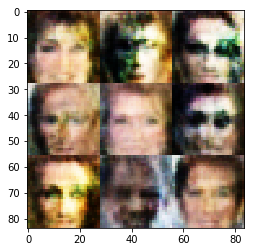

Epoch 1/1... Step: 1720: Discriminator Loss: 1.4806... Generator Loss: 0.7181
Epoch 1/1... Step: 1740: Discriminator Loss: 1.4607... Generator Loss: 0.6215
Epoch 1/1... Step: 1760: Discriminator Loss: 1.4216... Generator Loss: 0.6399
Epoch 1/1... Step: 1780: Discriminator Loss: 1.3917... Generator Loss: 0.6480
Epoch 1/1... Step: 1800: Discriminator Loss: 1.4693... Generator Loss: 0.6529


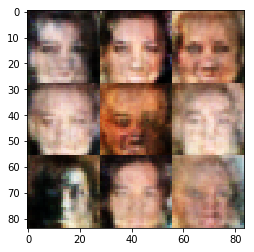

Epoch 1/1... Step: 1820: Discriminator Loss: 1.4814... Generator Loss: 0.6950
Epoch 1/1... Step: 1840: Discriminator Loss: 1.4817... Generator Loss: 0.6885
Epoch 1/1... Step: 1860: Discriminator Loss: 1.4482... Generator Loss: 0.6271
Epoch 1/1... Step: 1880: Discriminator Loss: 1.4973... Generator Loss: 0.6427
Epoch 1/1... Step: 1900: Discriminator Loss: 1.5169... Generator Loss: 0.6415


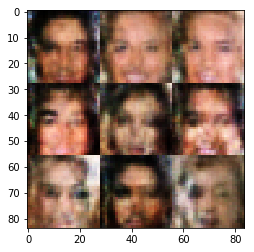

Epoch 1/1... Step: 1920: Discriminator Loss: 1.4543... Generator Loss: 0.6826
Epoch 1/1... Step: 1940: Discriminator Loss: 1.4569... Generator Loss: 0.7507
Epoch 1/1... Step: 1960: Discriminator Loss: 1.5359... Generator Loss: 0.6547
Epoch 1/1... Step: 1980: Discriminator Loss: 1.4271... Generator Loss: 0.6404
Epoch 1/1... Step: 2000: Discriminator Loss: 1.4884... Generator Loss: 0.6663


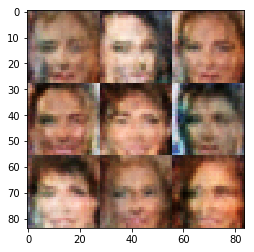

Epoch 1/1... Step: 2020: Discriminator Loss: 1.4979... Generator Loss: 0.6609
Epoch 1/1... Step: 2040: Discriminator Loss: 1.5518... Generator Loss: 0.6508
Epoch 1/1... Step: 2060: Discriminator Loss: 1.4012... Generator Loss: 0.6858
Epoch 1/1... Step: 2080: Discriminator Loss: 1.4092... Generator Loss: 0.6896
Epoch 1/1... Step: 2100: Discriminator Loss: 1.3950... Generator Loss: 0.7072


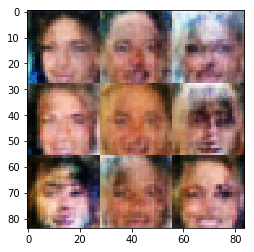

Epoch 1/1... Step: 2120: Discriminator Loss: 1.4350... Generator Loss: 0.6708
Epoch 1/1... Step: 2140: Discriminator Loss: 1.4616... Generator Loss: 0.6464
Epoch 1/1... Step: 2160: Discriminator Loss: 1.4400... Generator Loss: 0.6490
Epoch 1/1... Step: 2180: Discriminator Loss: 1.4656... Generator Loss: 0.6759
Epoch 1/1... Step: 2200: Discriminator Loss: 1.5303... Generator Loss: 0.7003


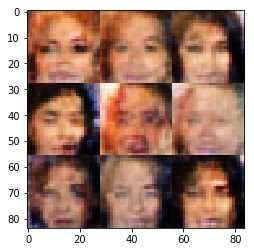

Epoch 1/1... Step: 2220: Discriminator Loss: 1.4397... Generator Loss: 0.6881
Epoch 1/1... Step: 2240: Discriminator Loss: 1.4181... Generator Loss: 0.6411
Epoch 1/1... Step: 2260: Discriminator Loss: 1.4999... Generator Loss: 0.6501
Epoch 1/1... Step: 2280: Discriminator Loss: 1.4516... Generator Loss: 0.6405
Epoch 1/1... Step: 2300: Discriminator Loss: 1.4652... Generator Loss: 0.6788


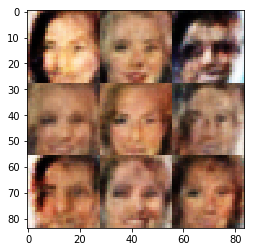

Epoch 1/1... Step: 2320: Discriminator Loss: 1.4514... Generator Loss: 0.6815
Epoch 1/1... Step: 2340: Discriminator Loss: 1.4397... Generator Loss: 0.6465
Epoch 1/1... Step: 2360: Discriminator Loss: 1.4551... Generator Loss: 0.6754
Epoch 1/1... Step: 2380: Discriminator Loss: 1.4843... Generator Loss: 0.6670
Epoch 1/1... Step: 2400: Discriminator Loss: 1.4491... Generator Loss: 0.7466


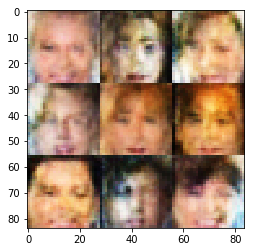

Epoch 1/1... Step: 2420: Discriminator Loss: 1.4434... Generator Loss: 0.6529
Epoch 1/1... Step: 2440: Discriminator Loss: 1.4523... Generator Loss: 0.6480
Epoch 1/1... Step: 2460: Discriminator Loss: 1.4126... Generator Loss: 0.6853
Epoch 1/1... Step: 2480: Discriminator Loss: 1.5371... Generator Loss: 0.6812
Epoch 1/1... Step: 2500: Discriminator Loss: 1.4803... Generator Loss: 0.7619


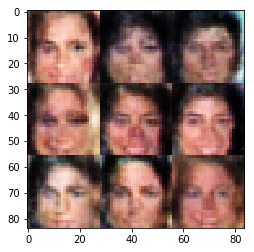

Epoch 1/1... Step: 2520: Discriminator Loss: 1.4748... Generator Loss: 0.6832
Epoch 1/1... Step: 2540: Discriminator Loss: 1.4536... Generator Loss: 0.6460
Epoch 1/1... Step: 2560: Discriminator Loss: 1.4911... Generator Loss: 0.6676
Epoch 1/1... Step: 2580: Discriminator Loss: 1.4571... Generator Loss: 0.6236
Epoch 1/1... Step: 2600: Discriminator Loss: 1.4528... Generator Loss: 0.7073


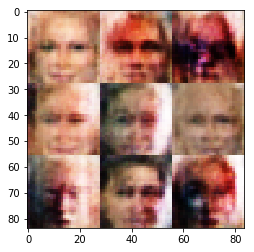

Epoch 1/1... Step: 2620: Discriminator Loss: 1.4193... Generator Loss: 0.7204
Epoch 1/1... Step: 2640: Discriminator Loss: 1.4743... Generator Loss: 0.6996
Epoch 1/1... Step: 2660: Discriminator Loss: 1.4505... Generator Loss: 0.6437
Epoch 1/1... Step: 2680: Discriminator Loss: 1.4049... Generator Loss: 0.6783
Epoch 1/1... Step: 2700: Discriminator Loss: 1.4864... Generator Loss: 0.7219


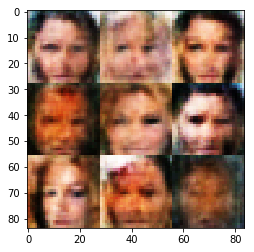

Epoch 1/1... Step: 2720: Discriminator Loss: 1.4894... Generator Loss: 0.6435
Epoch 1/1... Step: 2740: Discriminator Loss: 1.5109... Generator Loss: 0.6940
Epoch 1/1... Step: 2760: Discriminator Loss: 1.4925... Generator Loss: 0.7447
Epoch 1/1... Step: 2780: Discriminator Loss: 1.3934... Generator Loss: 0.6547
Epoch 1/1... Step: 2800: Discriminator Loss: 1.4845... Generator Loss: 0.6591


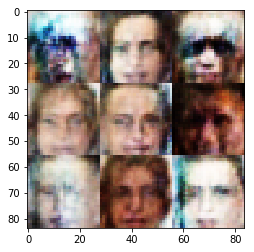

Epoch 1/1... Step: 2820: Discriminator Loss: 1.4331... Generator Loss: 0.6648
Epoch 1/1... Step: 2840: Discriminator Loss: 1.4729... Generator Loss: 0.7252
Epoch 1/1... Step: 2860: Discriminator Loss: 1.3927... Generator Loss: 0.6836
Epoch 1/1... Step: 2880: Discriminator Loss: 1.4116... Generator Loss: 0.6971
Epoch 1/1... Step: 2900: Discriminator Loss: 1.4153... Generator Loss: 0.6700


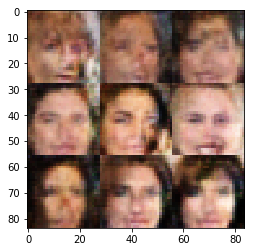

Epoch 1/1... Step: 2920: Discriminator Loss: 1.4240... Generator Loss: 0.6766
Epoch 1/1... Step: 2940: Discriminator Loss: 1.4138... Generator Loss: 0.7465
Epoch 1/1... Step: 2960: Discriminator Loss: 1.4360... Generator Loss: 0.6332
Epoch 1/1... Step: 2980: Discriminator Loss: 1.4046... Generator Loss: 0.7147
Epoch 1/1... Step: 3000: Discriminator Loss: 1.4432... Generator Loss: 0.6589


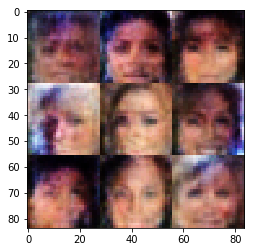

Epoch 1/1... Step: 3020: Discriminator Loss: 1.4646... Generator Loss: 0.6674
Epoch 1/1... Step: 3040: Discriminator Loss: 1.3904... Generator Loss: 0.6554
Epoch 1/1... Step: 3060: Discriminator Loss: 1.4443... Generator Loss: 0.6891
Epoch 1/1... Step: 3080: Discriminator Loss: 1.4908... Generator Loss: 0.6595
Epoch 1/1... Step: 3100: Discriminator Loss: 1.4336... Generator Loss: 0.6768


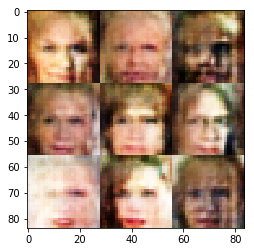

Epoch 1/1... Step: 3120: Discriminator Loss: 1.4293... Generator Loss: 0.6715
Epoch 1/1... Step: 3140: Discriminator Loss: 1.4661... Generator Loss: 0.6525
Epoch 1/1... Step: 3160: Discriminator Loss: 1.4534... Generator Loss: 0.7078
Epoch 1/1... Step: 3180: Discriminator Loss: 1.4205... Generator Loss: 0.7103
Epoch 1/1... Step: 3200: Discriminator Loss: 1.5062... Generator Loss: 0.6440


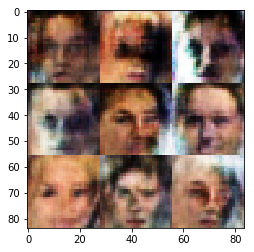

Epoch 1/1... Step: 3220: Discriminator Loss: 1.4600... Generator Loss: 0.6617
Epoch 1/1... Step: 3240: Discriminator Loss: 1.4195... Generator Loss: 0.7016
Epoch 1/1... Step: 3260: Discriminator Loss: 1.4938... Generator Loss: 0.6868
Epoch 1/1... Step: 3280: Discriminator Loss: 1.4044... Generator Loss: 0.6886
Epoch 1/1... Step: 3300: Discriminator Loss: 1.4261... Generator Loss: 0.6923


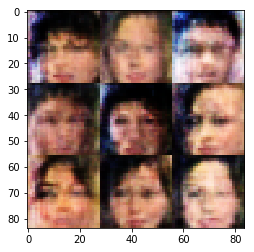

Epoch 1/1... Step: 3320: Discriminator Loss: 1.4535... Generator Loss: 0.6341
Epoch 1/1... Step: 3340: Discriminator Loss: 1.4590... Generator Loss: 0.6873
Epoch 1/1... Step: 3360: Discriminator Loss: 1.4177... Generator Loss: 0.6735
Epoch 1/1... Step: 3380: Discriminator Loss: 1.3860... Generator Loss: 0.7023
Epoch 1/1... Step: 3400: Discriminator Loss: 1.4152... Generator Loss: 0.6477


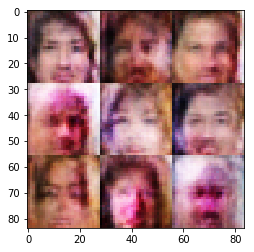

Epoch 1/1... Step: 3420: Discriminator Loss: 1.4114... Generator Loss: 0.6261
Epoch 1/1... Step: 3440: Discriminator Loss: 1.4223... Generator Loss: 0.7127
Epoch 1/1... Step: 3460: Discriminator Loss: 1.3975... Generator Loss: 0.6717
Epoch 1/1... Step: 3480: Discriminator Loss: 1.3811... Generator Loss: 0.6675
Epoch 1/1... Step: 3500: Discriminator Loss: 1.3942... Generator Loss: 0.6841


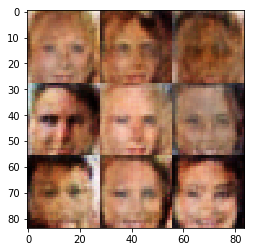

Epoch 1/1... Step: 3520: Discriminator Loss: 1.4149... Generator Loss: 0.6587
Epoch 1/1... Step: 3540: Discriminator Loss: 1.4592... Generator Loss: 0.6697
Epoch 1/1... Step: 3560: Discriminator Loss: 1.4085... Generator Loss: 0.6584
Epoch 1/1... Step: 3580: Discriminator Loss: 1.3825... Generator Loss: 0.7341
Epoch 1/1... Step: 3600: Discriminator Loss: 1.3999... Generator Loss: 0.6886


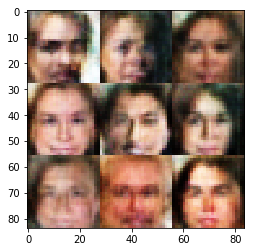

Epoch 1/1... Step: 3620: Discriminator Loss: 1.5035... Generator Loss: 0.6944
Epoch 1/1... Step: 3640: Discriminator Loss: 1.4235... Generator Loss: 0.6835
Epoch 1/1... Step: 3660: Discriminator Loss: 1.4168... Generator Loss: 0.6937
Epoch 1/1... Step: 3680: Discriminator Loss: 1.4440... Generator Loss: 0.7196
Epoch 1/1... Step: 3700: Discriminator Loss: 1.4207... Generator Loss: 0.6864


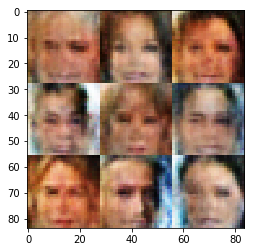

Epoch 1/1... Step: 3720: Discriminator Loss: 1.4487... Generator Loss: 0.7206
Epoch 1/1... Step: 3740: Discriminator Loss: 1.4274... Generator Loss: 0.6834
Epoch 1/1... Step: 3760: Discriminator Loss: 1.4433... Generator Loss: 0.6700
Epoch 1/1... Step: 3780: Discriminator Loss: 1.4074... Generator Loss: 0.6573
Epoch 1/1... Step: 3800: Discriminator Loss: 1.4400... Generator Loss: 0.7071


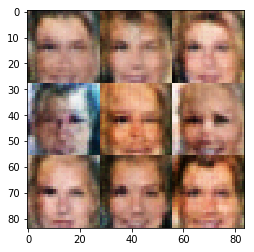

Epoch 1/1... Step: 3820: Discriminator Loss: 1.3678... Generator Loss: 0.6828
Epoch 1/1... Step: 3840: Discriminator Loss: 1.4202... Generator Loss: 0.6850
Epoch 1/1... Step: 3860: Discriminator Loss: 1.4258... Generator Loss: 0.6547
Epoch 1/1... Step: 3880: Discriminator Loss: 1.4179... Generator Loss: 0.6472
Epoch 1/1... Step: 3900: Discriminator Loss: 1.4127... Generator Loss: 0.6791


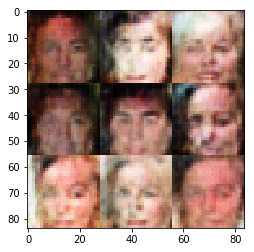

Epoch 1/1... Step: 3920: Discriminator Loss: 1.4447... Generator Loss: 0.6953
Epoch 1/1... Step: 3940: Discriminator Loss: 1.4561... Generator Loss: 0.6642
Epoch 1/1... Step: 3960: Discriminator Loss: 1.4334... Generator Loss: 0.6563
Epoch 1/1... Step: 3980: Discriminator Loss: 1.4340... Generator Loss: 0.6750
Epoch 1/1... Step: 4000: Discriminator Loss: 1.4271... Generator Loss: 0.6513


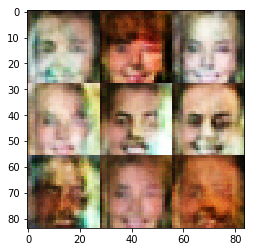

Epoch 1/1... Step: 4020: Discriminator Loss: 1.4036... Generator Loss: 0.6751
Epoch 1/1... Step: 4040: Discriminator Loss: 1.4003... Generator Loss: 0.6989
Epoch 1/1... Step: 4060: Discriminator Loss: 1.3871... Generator Loss: 0.6475
Epoch 1/1... Step: 4080: Discriminator Loss: 1.4372... Generator Loss: 0.6843
Epoch 1/1... Step: 4100: Discriminator Loss: 1.4005... Generator Loss: 0.6925


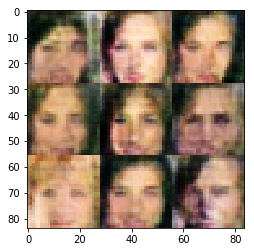

Epoch 1/1... Step: 4120: Discriminator Loss: 1.4365... Generator Loss: 0.7148
Epoch 1/1... Step: 4140: Discriminator Loss: 1.3721... Generator Loss: 0.6487
Epoch 1/1... Step: 4160: Discriminator Loss: 1.3763... Generator Loss: 0.6717
Epoch 1/1... Step: 4180: Discriminator Loss: 1.3700... Generator Loss: 0.7111
Epoch 1/1... Step: 4200: Discriminator Loss: 1.4412... Generator Loss: 0.6308


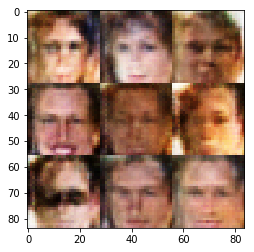

Epoch 1/1... Step: 4220: Discriminator Loss: 1.4082... Generator Loss: 0.7087
Epoch 1/1... Step: 4240: Discriminator Loss: 1.4426... Generator Loss: 0.6452
Epoch 1/1... Step: 4260: Discriminator Loss: 1.4356... Generator Loss: 0.6942
Epoch 1/1... Step: 4280: Discriminator Loss: 1.4147... Generator Loss: 0.7172
Epoch 1/1... Step: 4300: Discriminator Loss: 1.4142... Generator Loss: 0.7027


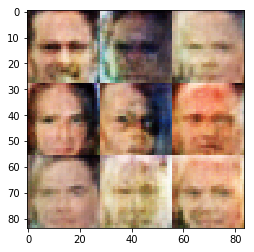

Epoch 1/1... Step: 4320: Discriminator Loss: 1.4625... Generator Loss: 0.7105
Epoch 1/1... Step: 4340: Discriminator Loss: 1.4007... Generator Loss: 0.7298
Epoch 1/1... Step: 4360: Discriminator Loss: 1.4635... Generator Loss: 0.6753
Epoch 1/1... Step: 4380: Discriminator Loss: 1.4165... Generator Loss: 0.6696
Epoch 1/1... Step: 4400: Discriminator Loss: 1.3891... Generator Loss: 0.6711


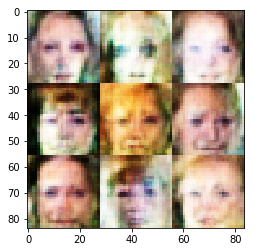

Epoch 1/1... Step: 4420: Discriminator Loss: 1.4247... Generator Loss: 0.6834
Epoch 1/1... Step: 4440: Discriminator Loss: 1.4271... Generator Loss: 0.6765
Epoch 1/1... Step: 4460: Discriminator Loss: 1.4147... Generator Loss: 0.7078
Epoch 1/1... Step: 4480: Discriminator Loss: 1.4129... Generator Loss: 0.6725
Epoch 1/1... Step: 4500: Discriminator Loss: 1.4652... Generator Loss: 0.7064


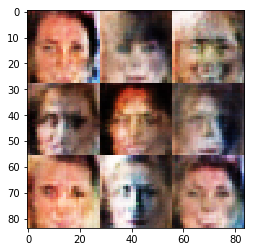

Epoch 1/1... Step: 4520: Discriminator Loss: 1.3737... Generator Loss: 0.7037
Epoch 1/1... Step: 4540: Discriminator Loss: 1.4752... Generator Loss: 0.6545
Epoch 1/1... Step: 4560: Discriminator Loss: 1.4114... Generator Loss: 0.6604
Epoch 1/1... Step: 4580: Discriminator Loss: 1.4189... Generator Loss: 0.6930
Epoch 1/1... Step: 4600: Discriminator Loss: 1.4341... Generator Loss: 0.6717


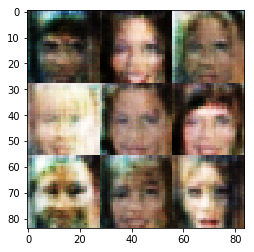

Epoch 1/1... Step: 4620: Discriminator Loss: 1.4103... Generator Loss: 0.6660
Epoch 1/1... Step: 4640: Discriminator Loss: 1.4183... Generator Loss: 0.7051
Epoch 1/1... Step: 4660: Discriminator Loss: 1.4275... Generator Loss: 0.6616
Epoch 1/1... Step: 4680: Discriminator Loss: 1.4312... Generator Loss: 0.6669
Epoch 1/1... Step: 4700: Discriminator Loss: 1.4309... Generator Loss: 0.6971


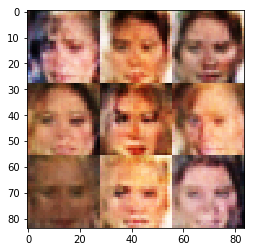

Epoch 1/1... Step: 4720: Discriminator Loss: 1.4321... Generator Loss: 0.6739
Epoch 1/1... Step: 4740: Discriminator Loss: 1.4461... Generator Loss: 0.7089
Epoch 1/1... Step: 4760: Discriminator Loss: 1.4515... Generator Loss: 0.6705
Epoch 1/1... Step: 4780: Discriminator Loss: 1.4001... Generator Loss: 0.6484
Epoch 1/1... Step: 4800: Discriminator Loss: 1.4085... Generator Loss: 0.6407


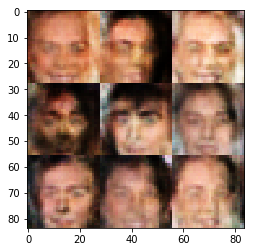

Epoch 1/1... Step: 4820: Discriminator Loss: 1.4335... Generator Loss: 0.6213
Epoch 1/1... Step: 4840: Discriminator Loss: 1.4267... Generator Loss: 0.6759
Epoch 1/1... Step: 4860: Discriminator Loss: 1.4640... Generator Loss: 0.6782
Epoch 1/1... Step: 4880: Discriminator Loss: 1.4103... Generator Loss: 0.6961
Epoch 1/1... Step: 4900: Discriminator Loss: 1.4264... Generator Loss: 0.7047


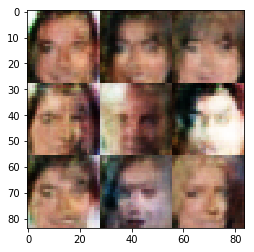

Epoch 1/1... Step: 4920: Discriminator Loss: 1.4338... Generator Loss: 0.6917
Epoch 1/1... Step: 4940: Discriminator Loss: 1.4192... Generator Loss: 0.6730
Epoch 1/1... Step: 4960: Discriminator Loss: 1.4035... Generator Loss: 0.6734
Epoch 1/1... Step: 4980: Discriminator Loss: 1.4340... Generator Loss: 0.7271
Epoch 1/1... Step: 5000: Discriminator Loss: 1.4338... Generator Loss: 0.6329


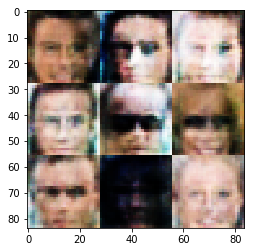

Epoch 1/1... Step: 5020: Discriminator Loss: 1.4034... Generator Loss: 0.6616
Epoch 1/1... Step: 5040: Discriminator Loss: 1.4157... Generator Loss: 0.6901
Epoch 1/1... Step: 5060: Discriminator Loss: 1.4143... Generator Loss: 0.7286
Epoch 1/1... Step: 5080: Discriminator Loss: 1.4319... Generator Loss: 0.6487
Epoch 1/1... Step: 5100: Discriminator Loss: 1.4439... Generator Loss: 0.6943


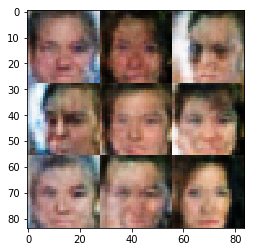

Epoch 1/1... Step: 5120: Discriminator Loss: 1.4100... Generator Loss: 0.6473
Epoch 1/1... Step: 5140: Discriminator Loss: 1.4501... Generator Loss: 0.6910
Epoch 1/1... Step: 5160: Discriminator Loss: 1.4043... Generator Loss: 0.6800
Epoch 1/1... Step: 5180: Discriminator Loss: 1.4136... Generator Loss: 0.6525
Epoch 1/1... Step: 5200: Discriminator Loss: 1.4245... Generator Loss: 0.6637


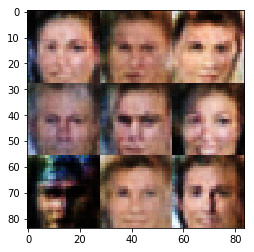

Epoch 1/1... Step: 5220: Discriminator Loss: 1.3813... Generator Loss: 0.6430
Epoch 1/1... Step: 5240: Discriminator Loss: 1.4204... Generator Loss: 0.6486
Epoch 1/1... Step: 5260: Discriminator Loss: 1.3804... Generator Loss: 0.6918
Epoch 1/1... Step: 5280: Discriminator Loss: 1.4233... Generator Loss: 0.6745
Epoch 1/1... Step: 5300: Discriminator Loss: 1.3889... Generator Loss: 0.7118


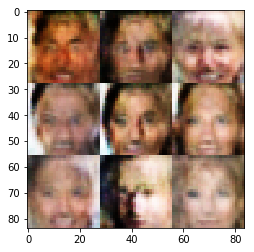

Epoch 1/1... Step: 5320: Discriminator Loss: 1.4646... Generator Loss: 0.6534
Epoch 1/1... Step: 5340: Discriminator Loss: 1.4262... Generator Loss: 0.6822
Epoch 1/1... Step: 5360: Discriminator Loss: 1.4380... Generator Loss: 0.6430
Epoch 1/1... Step: 5380: Discriminator Loss: 1.4319... Generator Loss: 0.6866
Epoch 1/1... Step: 5400: Discriminator Loss: 1.3927... Generator Loss: 0.6595


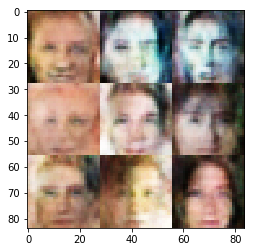

Epoch 1/1... Step: 5420: Discriminator Loss: 1.4054... Generator Loss: 0.7191
Epoch 1/1... Step: 5440: Discriminator Loss: 1.4104... Generator Loss: 0.6655
Epoch 1/1... Step: 5460: Discriminator Loss: 1.4111... Generator Loss: 0.6815
Epoch 1/1... Step: 5480: Discriminator Loss: 1.4194... Generator Loss: 0.6540
Epoch 1/1... Step: 5500: Discriminator Loss: 1.3995... Generator Loss: 0.6790


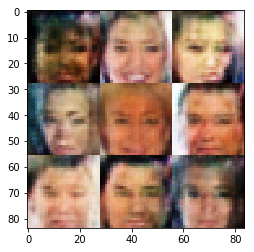

Epoch 1/1... Step: 5520: Discriminator Loss: 1.4288... Generator Loss: 0.6679
Epoch 1/1... Step: 5540: Discriminator Loss: 1.4425... Generator Loss: 0.6300
Epoch 1/1... Step: 5560: Discriminator Loss: 1.4125... Generator Loss: 0.7010
Epoch 1/1... Step: 5580: Discriminator Loss: 1.4016... Generator Loss: 0.6482
Epoch 1/1... Step: 5600: Discriminator Loss: 1.4421... Generator Loss: 0.6949


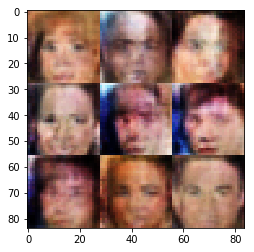

Epoch 1/1... Step: 5620: Discriminator Loss: 1.4247... Generator Loss: 0.6833
Epoch 1/1... Step: 5640: Discriminator Loss: 1.4133... Generator Loss: 0.6853
Epoch 1/1... Step: 5660: Discriminator Loss: 1.4180... Generator Loss: 0.6982
Epoch 1/1... Step: 5680: Discriminator Loss: 1.3953... Generator Loss: 0.7071
Epoch 1/1... Step: 5700: Discriminator Loss: 1.4217... Generator Loss: 0.7154


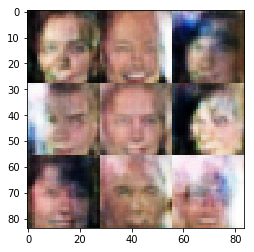

Epoch 1/1... Step: 5720: Discriminator Loss: 1.3952... Generator Loss: 0.6936
Epoch 1/1... Step: 5740: Discriminator Loss: 1.4334... Generator Loss: 0.6596
Epoch 1/1... Step: 5760: Discriminator Loss: 1.4111... Generator Loss: 0.6755
Epoch 1/1... Step: 5780: Discriminator Loss: 1.4009... Generator Loss: 0.6717
Epoch 1/1... Step: 5800: Discriminator Loss: 1.4257... Generator Loss: 0.7038


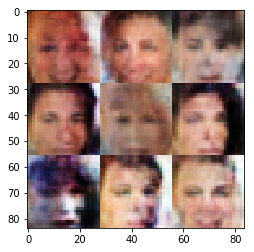

Epoch 1/1... Step: 5820: Discriminator Loss: 1.3991... Generator Loss: 0.6777
Epoch 1/1... Step: 5840: Discriminator Loss: 1.4012... Generator Loss: 0.6591
Epoch 1/1... Step: 5860: Discriminator Loss: 1.4415... Generator Loss: 0.6785
Epoch 1/1... Step: 5880: Discriminator Loss: 1.3913... Generator Loss: 0.7045
Epoch 1/1... Step: 5900: Discriminator Loss: 1.4147... Generator Loss: 0.6700


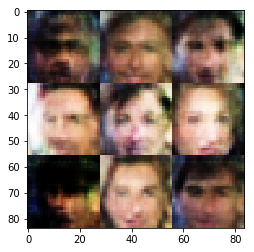

Epoch 1/1... Step: 5920: Discriminator Loss: 1.3822... Generator Loss: 0.6694
Epoch 1/1... Step: 5940: Discriminator Loss: 1.3888... Generator Loss: 0.6904
Epoch 1/1... Step: 5960: Discriminator Loss: 1.3880... Generator Loss: 0.7038
Epoch 1/1... Step: 5980: Discriminator Loss: 1.3860... Generator Loss: 0.6912
Epoch 1/1... Step: 6000: Discriminator Loss: 1.4088... Generator Loss: 0.6666


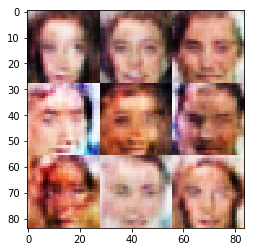

Epoch 1/1... Step: 6020: Discriminator Loss: 1.4076... Generator Loss: 0.7140
Epoch 1/1... Step: 6040: Discriminator Loss: 1.4039... Generator Loss: 0.6887
Epoch 1/1... Step: 6060: Discriminator Loss: 1.3812... Generator Loss: 0.7052
Epoch 1/1... Step: 6080: Discriminator Loss: 1.4191... Generator Loss: 0.6741
Epoch 1/1... Step: 6100: Discriminator Loss: 1.4181... Generator Loss: 0.7013


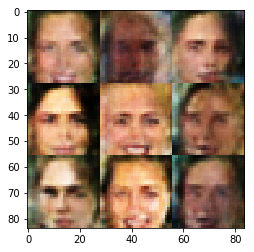

Epoch 1/1... Step: 6120: Discriminator Loss: 1.4360... Generator Loss: 0.7053
Epoch 1/1... Step: 6140: Discriminator Loss: 1.4173... Generator Loss: 0.6595
Epoch 1/1... Step: 6160: Discriminator Loss: 1.4096... Generator Loss: 0.6930
Epoch 1/1... Step: 6180: Discriminator Loss: 1.4413... Generator Loss: 0.6921
Epoch 1/1... Step: 6200: Discriminator Loss: 1.4300... Generator Loss: 0.7038


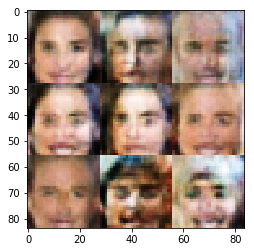

Epoch 1/1... Step: 6220: Discriminator Loss: 1.4120... Generator Loss: 0.7022
Epoch 1/1... Step: 6240: Discriminator Loss: 1.4045... Generator Loss: 0.6833
Epoch 1/1... Step: 6260: Discriminator Loss: 1.4335... Generator Loss: 0.6798
Epoch 1/1... Step: 6280: Discriminator Loss: 1.4410... Generator Loss: 0.6663
Epoch 1/1... Step: 6300: Discriminator Loss: 1.4152... Generator Loss: 0.6715


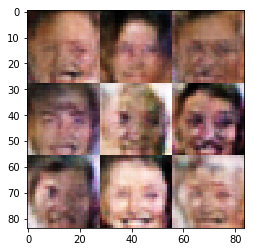

Epoch 1/1... Step: 6320: Discriminator Loss: 1.4011... Generator Loss: 0.6818


In [56]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.